In [1]:
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
from collections import defaultdict
import seaborn as sns
from tqdm import tqdm
import matplotlib.patches as mpatches

import eye_metrics_utils
import data_utils
import gaze_entropy

# Define ROI area

In [5]:
# all the ROIs
label = {"standby_ASI": [(534, 424), 50, "c"], # [(cx,cy), radius, type: "c" = circle]  
         "standby_AH": [(528,530), 50, "c"],
         "standby_ALT": [(523, 626), 45, "c"], 
         "RPM_LEFT": [(633, 411), (672, 451), "r"], #[(topleft_x,y), (bottomright_x,y), type: "r" = rectangle]  
         "G1000_ASI": [(674, 432), (705, 525), "r"],
         "G1000_AI": [(720, 413), (790, 495), "r"],
         "HSI": [(742, 556), 45, "c"],
         "G1000_ALT": [(797, 428), (852, 523), "r"],
         "NRST_Box": [(792, 534), (876, 554), "r"],
         "RPM_RIGHT": [(1054, 440), 30, "c"],
         "outside": [(0,0), (1280, 350), "r"]}

encode_table={
    "standby_ASI": "P",
    "standby_AH": "Q",
    "standby_ALT": "R",
    "RPM_LEFT": "A",
    "G1000_ASI": "B",
    "G1000_AI": "C",
    "HSI": "D",
    "G1000_ALT": "E", 
    "NRST_Box": "F",
    "RPM_RIGHT": "I",
    "outside": "X",
    "unknown": "Z"
}

In [6]:
# modified ROIs
label = {"outside": [(0,0), (1280, 350), "r"],
         "left_panel": [(480, 370), (580, 660), "r"],
         "ASI": [(600, 400), (705, 525), "r"],
         "ALT": [(790, 428), (876, 554), "r"],
         "HSI": [(742, 556), 45, "c"]
}

encode_table = {
    "left_panel": "P",
    "ASI": "B",
    "HSI": "D",
    "ALT": "E",
    "outside": "X",
    "unknown": "Z"
}

In [7]:
img = cv2.imread("flight.jpg")

overlay = img.copy()
thickness = -1

h,w,c = img.shape

In [8]:
pdict = defaultdict()
for key in label:
    if label[key][-1] == "c":
        mask = np.zeros((h,w), np.uint8)
        cv2.circle(mask,label[key][0], label[key][1],255,-1)
        points = np.where(mask==255)
        pdict[key] = points
    elif label[key][-1] == "r":
        mask = np.zeros((h,w), np.uint8)
        cv2.rectangle(mask,label[key][0], label[key][1],255,-1)
        points = np.where(mask==255)
        pdict[key] = points

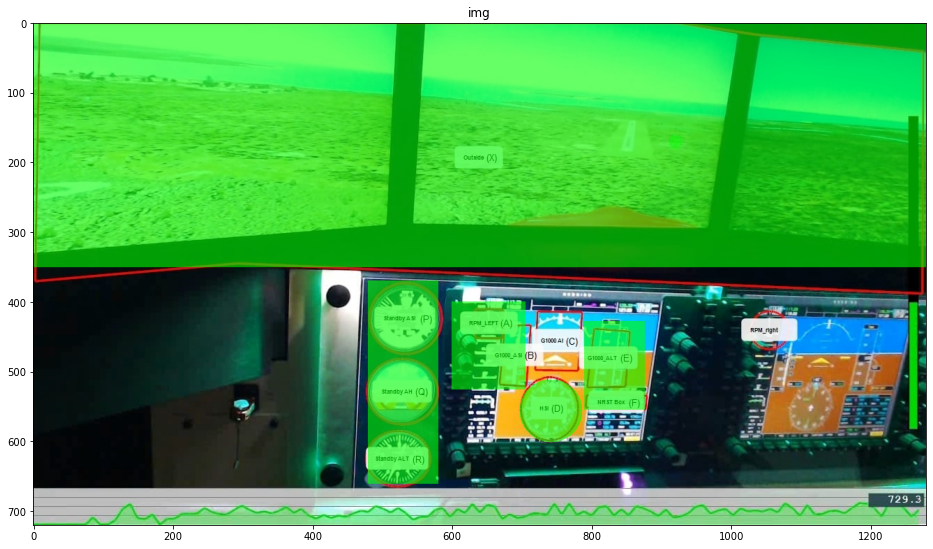

In [9]:
color = (0,255,0)

for key in pdict:
    overlay[pdict[key]] = color
    
alpha = 0.6

# Following line overlays transparent rectangle over the image
image_new = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)
figure =plt.figure(figsize=(16,10))
plt.imshow(cv2.cvtColor(image_new, cv2.COLOR_BGR2RGB))
plt.title('img')
plt.show()

In [10]:
# for i in range(len(label.values())):
#     img = cv2.addText(list(encode_table.values())[i], )

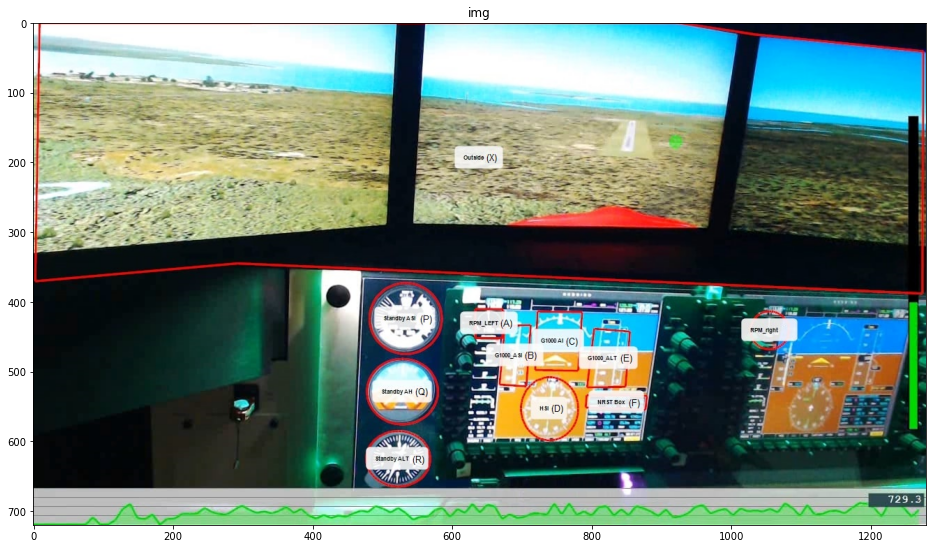

In [11]:
figure =plt.figure(figsize=(16,10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('img')
plt.show()

# Get scanpath functions

In [12]:
def dist_func(point, v1, v2, type="c"): #between points and rectange/cirle
    #point: x, y
    #v1,v2: topleft,bottomright if type = "r"
    #v1,v2: center (x,y),  if type = "c"
    d = 0
    if type == "r":
        dx = max(v1[0] - point[0], 0, point[0] - v2[0])
        dy = max(v1[1] - point[1], 0, point[1] - v2[1])
        
        d = np.sqrt(dx*dx + dy*dy)
    elif type == "c":
        d = np.sqrt((point[0]-v1[0])**2 + (point[1]-v1[1])**2) - v2
        
    return d

In [13]:
def offset(df_data, x_offset = - 15, y_offset = 15, x_name = "X Pos", y_name = "Y Pos"):
    df_x = df_data.copy()
    df_x[x_name] = df_x[x_name] + x_offset
    df_x[y_name] = df_x[y_name] + y_offset
    
    return df_x

In [14]:
def encode(lst_transition):
    str_transition = ""
    for v in lst_transition:
        str_transition = str_transition + encode_table[v]
    return str_transition

def decode(str_transition):
    lst_transition = []
    for v in str_transition:
        key_index = list(encode_table.values()).index(v)
        lst_transition.append(list(encode_table.keys())[key_index])
    return lst_transition

# encode(['outside', 'RPM_LEFT', 'G1000_ASI', 'outside'])
# decode("XABX")
encode(['outside', 'ALT'])

'XE'

In [15]:
def get_scanpath(df_data):
    df_x = df_data.copy()
    
    if (len(df_data[df_data["Display"] == -1])/len(df_data) > 0.30): # if missing value > 30%, remove
        return [], pd.DataFrame()
    
    Efix = eye_metrics_utils.detect_fixations(df_x, max_dist = 10, min_dur = 6, is_cleanup = True)
    
    l = []

    for i, fix in enumerate(Efix):
        point = np.array([fix[4], fix[3]], dtype ="int64")
        
        d = [dist_func((point[1],point[0]), v1,v2,type) for v1,v2,type in label.values()]
        order = np.argsort(d)
        if 0.0 not in d:
            threshold = 20
            if d[order[0]] > threshold:
                key = "unknown"
            else:
                key = list(pdict.keys())[order[0]]
        else:
            for o in order:
                key = "unknown"
                points = np.transpose(list(pdict.values())[o])
                if any((points[:]==point).all(1)):
                    key = list(pdict.keys())[o]
                    break
        
        Efix[i].append(key)
        l.append(key)
    str_transition = encode(l)
    
    return str_transition, Efix

In [16]:
def merge_consecutive_fixations_in_same_roi(efix):
    if(len(efix) == 0):
        return efix
    df_efix = pd.DataFrame(efix, columns=["start", "stop", "duration", "x", "y", "roi"])
    df_efix['value_grp'] = (df_efix.roi != df_efix.roi.shift()).cumsum()

    return pd.DataFrame({'start' : df_efix.groupby('value_grp').start.first(), 
                          'stop' : df_efix.groupby('value_grp').stop.last(),
                          'duration' : df_efix.groupby('value_grp').duration.sum(), 
                          'x' : df_efix.groupby('value_grp').x.mean(),
                          'y': df_efix.groupby('value_grp').y.mean(),
                          'roi': df_efix.groupby('value_grp').roi.first()
                         }).reset_index(drop=True).to_numpy()

In [17]:
def get_feature_from_fixation(efix):
    df_fix = merge_consecutive_fixations_in_same_roi(efix)
    df_fix = pd.DataFrame(efix, columns=['start','stop','fix_dur','x','y','roi'])
    total_dur = np.sum(df_fix["fix_dur"])

    f = defaultdict(dict)
    for key in label.keys():
        df_f = df_fix[df_fix['roi'] == key]
        if len(df_f['fix_dur']) == 0:
            f[key]['fix_dur'] = 0
            f[key]['fix_rate'] = 0
            f[key]['fix_percent'] = 0
        else:
            f[key]['fix_dur'] = np.median(df_f['fix_dur'])
#             f[key]['fix_rate'] = df_f['fix_dur'].sum()/df_fix['fix_dur'].sum()
#             f[key]['fix_rate'] = len(df_f['fix_dur'])/len(df_fix)            
            f[key]['fix_rate'] = (1000/60)*len(df_f['fix_dur'])/(df_fix.iloc[-1]['stop'] - df_fix.iloc[0]['start'])
            f[key]['fix_percent'] = np.sum(df_f['fix_dur'])/total_dur

    return f

In [18]:
import re
# st = "FXCEFXXEFXBZXXXXXEFXDBXZXXEDXCBXFXXXXZ"

def replace_repeated_character(st): 
    return re.sub(r'(\w)\1+',r'\1', st)

In [19]:
def get_feature(df_data):
    df_x = df_data.copy()
    if (len(df_data[df_data["Display"] == -1])/len(df_data) > 0.30): # if missing value > 20%, remove
        return None, None
    
    total_time = df_x.iloc[-1]['Start Time (secs)'] - df_x.iloc[0]['Start Time (secs)']
    
    Eblk = eye_metrics_utils.detect_blinks(df_x)
    Esac = eye_metrics_utils.detect_saccades(df_x)
    
    blk_rate = (1000/60)*len(Eblk)/total_time
    sac_rate = (1000/60)*len(Esac)/total_time
    
    return blk_rate, sac_rate

In [20]:
def cal_entropy(transitions):
    if len(transitions) == 0:
        return 0, 0
#     transitions = replace_repeated_character(transitions)

    trans_matrix = create_transition_matrix(transitions)

    m = {}
    for c in trans_matrix.columns:
        m[c] = trans_matrix[c].tolist()

    Hs = 0
    Ht = 0
    pA = {c:len(np.where(np.array(list(transitions))==c)[0])/len(transitions) for c in list(set(transitions))}

    for k,v in pA.items():
        Hs += -1 * np.nan_to_num(v*np.log2(v))
        Ht += -sum(pA[k]*(np.nan_to_num(m[k]*np.log2(m[k]))))
        
    return Hs, Ht

In [21]:
def create_transition_matrix(transitions):
    m = pd.crosstab(pd.Series(list(transitions)[1:], name = "t+1"),
            pd.Series(list(transitions)[:-1], name = "t"),normalize=1)
        
    return m

# Run all data

In [22]:
import glob
csv_files = glob.glob("data/*.csv")
csv_files_two = [v for v in csv_files if "Two Gaze-Vergence" in v]

In [23]:
df_par = pd.read_csv("participant.csv")
group = [df_par[df_par['Group'].str.contains("1")]['ID'].tolist(), df_par[df_par['Group'].str.contains("2")]["ID"].tolist()]
group = [[i[-3:] for i in v] for v in group]

In [24]:
group2 = [df_par[df_par['Group'].str.contains(gr)]['ID'].tolist() for gr in ["A", "B", "C"]]
group2 = [[i[-3:] for i in v] for v in group2]
group2

[['032',
  '027',
  '031',
  '028',
  '004',
  '008',
  '010',
  '029',
  '003',
  '007',
  '023',
  '013',
  '024'],
 ['021', '006', '019', '022', '015', '016', '018', '033'],
 ['014', '005', '025', '002', '001', '020', '011', '017', '026', '012', '009']]

In [25]:
d = defaultdict(list)
Efixs = {}
for csv in csv_files_two:
    par_id = csv[14:17]
    
    df_data = pd.read_csv(csv)
    print(csv, len(df_data))
    
    if par_id in group2[0]:
        g = 1
    elif par_id in group2[1]:
        g = 2
    elif par_id in group2[2]:
        g = 3
    
    d['par_id'].append(par_id)
    d['group'].append(g)
    
    df_data = offset(df_data)
    
    transition, Efix = get_scanpath(df_data)
#     Efix = merge_consecutive_fixations_in_same_roi(Efix)
    d['transition'].append(transition)
    Efixs[par_id]=Efix
    f = get_feature_from_fixation(Efix)
    for key,v in f.items():
        d["{}_fix_dur".format(key)].append(v['fix_dur'])
        d["{}_fix_rate".format(key)].append(v['fix_rate'])
        d["{}_fix_percent".format(key)].append(v['fix_percent'])

    df_efix = pd.DataFrame(Efix, columns=["start", "stop", "duration", "x", "y", "roi"])
    fix_dur = df_efix["duration"].median()
    fix_rate = (1000/60)*len(df_efix)/(df_data.iloc[-1]['Start Time (secs)'] - df_data.iloc[0]['Start Time (secs)'])
    blk_rate, sac_rate = get_feature(df_data)

    d["fix_dur"].append(fix_dur)
    d["fix_rate"].append(fix_rate)
    d["blk_rate"].append(blk_rate)
    d["sac_rate"].append(sac_rate)

    Hs, Ht = cal_entropy(transition)
    d["Hs"].append(Hs)
    d["Ht"].append(Ht)  

data\PISSS_ID_001_Approach Two Gaze-Vergence.csv 9554
data\PISSS_ID_002_Approach Two Gaze-Vergence.csv 9430
data\PISSS_ID_003_Approach Two Gaze-Vergence.csv 9368
data\PISSS_ID_004_Approach Two Gaze-Vergence.csv 9862
data\PISSS_ID_005_Approach Two Gaze-Vergence.csv 9245
data\PISSS_ID_006_Approach Two Gaze-Vergence.csv 9739
data\PISSS_ID_007_Approach Two Gaze-Vergence.csv 9677
data\PISSS_ID_008_Approach Two Gaze-Vergence.csv 9923
data\PISSS_ID_009_Approach Two Gaze-Vergence.csv 9243
data\PISSS_ID_010_Approach Two Gaze-Vergence.csv 9923
data\PISSS_ID_011_Approach Two Gaze-Vergence.csv 9492
data\PISSS_ID_012_Approach Two Gaze-Vergence.csv 9431
data\PISSS_ID_013_Approach Two Gaze-Vergence.csv 8691
data\PISSS_ID_014_Approach Two Gaze-Vergence.csv 9307
data\PISSS_ID_015_Approach Two Gaze-Vergence.csv 8812
data\PISSS_ID_016_Approach Two Gaze-Vergence.csv 8259
data\PISSS_ID_017_Approach Two Gaze-Vergence.csv 9184
data\PISSS_ID_018_Approach Two Gaze-Vergence.csv 8937
data\PISSS_ID_019_Approach T

In [26]:
df_res = pd.DataFrame(d).sort_values(["group","par_id"]).dropna().reset_index()

In [27]:
exp = [df_par[df_par["ID"].str.contains(str(v).zfill(3))]["Flight_hour"].tolist()[0] for v in df_res["par_id"]]

In [28]:
df_res["exp"] = exp

In [29]:
all_gaze_strings = df_res['transition'].tolist()
all_gaze_strings = [replace_repeated_character(v) for v in all_gaze_strings]

In [26]:
substr = replace_repeated_character(df_res[["exp", "par_id", "transition"]].iloc[7]['transition'])
merged_efix = merge_consecutive_fixations_in_same_roi(Efixs["029"])
merged_efix

array([[666.557316, 667.028338, 0.4710219999999481, 912.1157413793104,
        279.9389724137931, 'outside'],
       [667.336384, 667.876383, 0.5399990000000798, 836.4217878787878,
        519.1706727272727, 'ALT'],
       [668.000388, 669.124457, 1.1240689999999631, 925.270668115942,
        278.8320231884058, 'outside'],
       [669.2684519999999, 669.967488, 0.6990360000000919,
        849.9243558139535, 570.2737999999999, 'ALT'],
       [670.110495, 670.306505, 0.19601000000000113, 917.9846750000002,
        279.00869166666666, 'outside'],
       [670.434515, 670.938556, 0.5040409999999156, 844.4368451612904,
        517.9538548387097, 'ALT'],
       [671.070546, 671.230553, 0.1600069999999505, 690.99755, 498.53929,
        'ASI'],
       [671.3765599999999, 672.5616200000001, 0.9690339999999651,
        918.2468989583332, 274.37095625, 'outside'],
       [672.7256639999999, 673.4366769999999, 0.7110129999999799,
        690.7376636363635, 492.90662272727275, 'ASI'],
       [673.61

In [27]:
start = Efixs["003"][0][0]
end = Efixs["003"][-1][1]
start, end

(780.017336, 931.993074)

In [28]:
# colors = plt.get_cmap('RdYlGn')(np.linspace(0, 1, 6))
colors = plt.get_cmap('hsv')(np.linspace(0, 0.9, 6))

color_codes = {
    "outside": colors[0],
    "left_panel": colors[1],
    "ASI": colors[2],
    "ALT": colors[3],
    "HSI": colors[4],
    "unknown": colors[5]
}



Text(0, 0.5, 'participant ID')

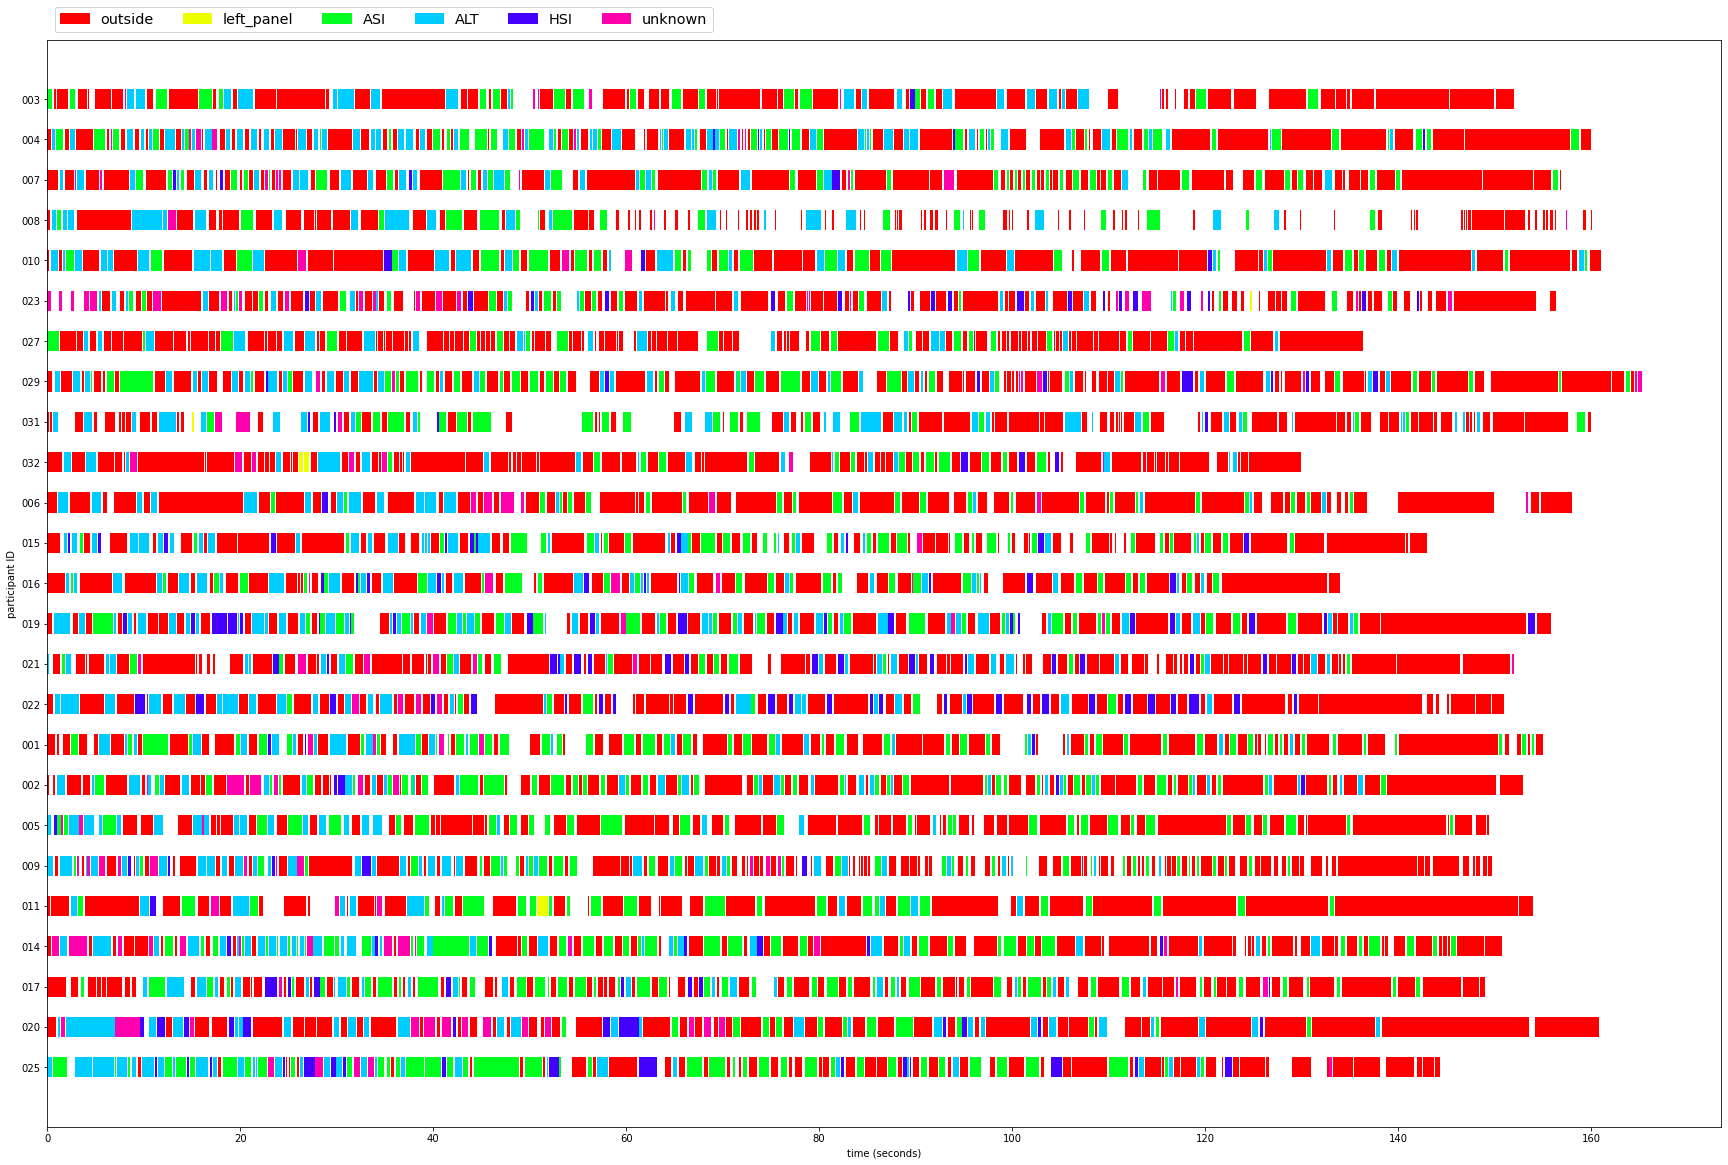

In [33]:
# width = fixation duration
fig, ax = plt.subplots(figsize=(30, 20))
ax.invert_yaxis()

for par_id in df_res["par_id"]:
    labels = par_id
    start = Efixs[par_id][0][0]
    widths = np.array(Efixs[par_id]).T[2].astype(float)
    starts = np.array(Efixs[par_id]).T[0].astype(float) - start
    cols = [color_codes[v] for v in np.array(Efixs[par_id]).T[5]]

    ax.barh(labels, widths, left=starts, height=0.5, color=cols)

color_patches = [mpatches.Patch(color=v, label=k) for k,v in color_codes.items()]
ax.legend(handles=color_patches, ncol=len(color_codes), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='x-large')

ax.set_xlabel("time (seconds)")
ax.set_ylabel("participant ID")


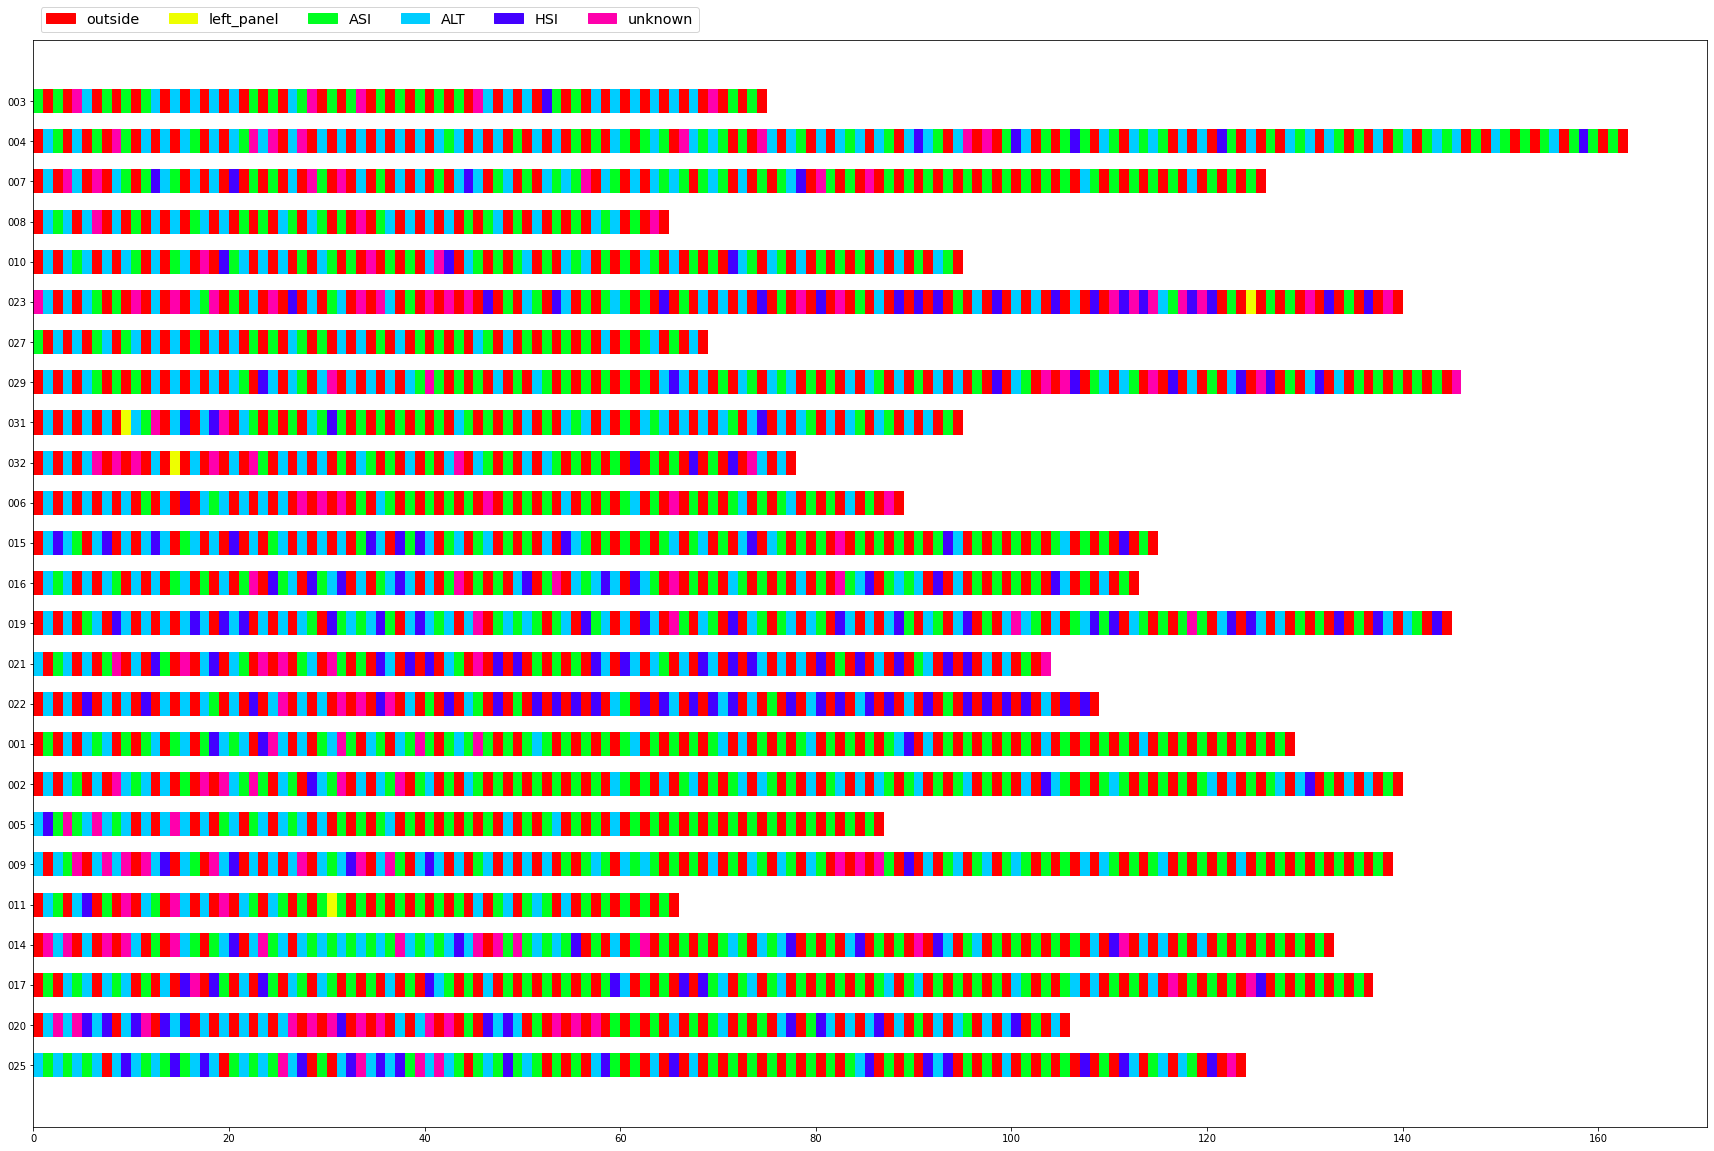

In [32]:
# equal width
fig, ax = plt.subplots(figsize=(30, 20))
ax.invert_yaxis()

for par_id in df_res["par_id"]:
    labels = par_id
    merged_efix = merge_consecutive_fixations_in_same_roi(Efixs[par_id])  
    start = merged_efix[0][0]
#     widths = np.array(merged_efix).T[2].astype(float)
#     starts = np.array(merged_efix).T[0].astype(float) - start
    widths = np.ones(len(merged_efix))
    starts = np.arange(len(merged_efix))
    cols = [color_codes[v] for v in np.array(merged_efix).T[5]]

    ax.barh(labels, widths, left=starts, height=0.6, color=cols)

color_patches = [mpatches.Patch(color=v, label=k) for k,v in color_codes.items()]
ax.legend(handles=color_patches, ncol=len(color_codes), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='x-large')
ax.set_ylabel("participant ID")

# Find subsequence frequency

## Among pilots

In [30]:
import STree

In [31]:
st = STree.STree(all_gaze_strings)
ws = st.word_starts

In [32]:
st.lcsm()

['BXEX', 'XEXB', 'EXBX']

In [33]:
np.array([len(v) for v in all_gaze_strings])

array([ 75, 163, 126,  65,  95, 140,  69, 146,  95,  78,  89, 115, 113,
       145, 104, 109, 129, 140,  87, 139,  66, 133, 137, 106, 124])

In [34]:
length = 5
# lsubseqcount = []
subseqcount = defaultdict(int)

# for gaze_string in all_gaze_strings[:16]:
for gaze_string in all_gaze_strings:

    for i in range(len(gaze_string)-length + 1):
        substring = gaze_string[i:i+length]
        subseqcount[substring] += 1
        
# sorted_subseqcount = {k: v for k, v in sorted(subseqcount.items(), key=lambda item: item[1], reverse=True)}
#     lsubseqcount.append(sorted_subseqcount)

In [86]:
# paridx = 4
# lsubseqcount[paridx]
# {k:v/sum(lsubseqcount[paridx].values()) for k,v in lsubseqcount[paridx].items()}
sorted_subseqcount = {k: v for k, v in sorted(subseqcount.items(), key=lambda item: item[1], reverse=True)}
sorted_subseqcount

{'BXBX': 13,
 'XBXB': 12,
 'EBEB': 4,
 'DXBX': 4,
 'XBXE': 4,
 'BEBE': 3,
 'EDXB': 3,
 'XBXD': 3,
 'BEXE': 2,
 'BEBD': 2,
 'EBDB': 2,
 'BDBE': 2,
 'DEXB': 2,
 'EXBE': 2,
 'XBEB': 2,
 'BXED': 2,
 'EBXB': 2,
 'BXBE': 2,
 'BXEX': 2,
 'XEXB': 2,
 'EXBX': 2,
 'BXDE': 2,
 'BXDX': 2,
 'EBEX': 1,
 'EXED': 1,
 'XEDE': 1,
 'EDEB': 1,
 'DEBE': 1,
 'DBED': 1,
 'BEDE': 1,
 'EDEX': 1,
 'BEBZ': 1,
 'EBZE': 1,
 'BZED': 1,
 'ZEDX': 1,
 'XEDZ': 1,
 'EDZE': 1,
 'DZED': 1,
 'ZEDE': 1,
 'EDED': 1,
 'DEDB': 1,
 'EDBZ': 1,
 'DBZE': 1,
 'BZEZ': 1,
 'ZEZE': 1,
 'EZEB': 1,
 'ZEBX': 1,
 'DBEB': 1,
 'BEBX': 1,
 'XEDB': 1,
 'EDBX': 1,
 'DBXB': 1,
 'XEXD': 1,
 'EXDX': 1,
 'XDXE': 1,
 'DXEX': 1,
 'XBED': 1,
 'BEDX': 1,
 'XDED': 1,
 'DEDX': 1,
 'XDXB': 1,
 'XDEX': 1,
 'XBEX': 1,
 'EXEB': 1,
 'XEBX': 1,
 'EBXD': 1,
 'XDXZ': 1,
 'DXZX': 1}

In [221]:
length = 3
lsubseqcount = defaultdict(dict)
par_ids = df_res["par_id"]
for par_id, gaze_string in zip(par_ids, all_gaze_strings):
    subseqcount = defaultdict(int)
    for i in range(len(gaze_string)-length + 1):
        substring = gaze_string[i:i+length]
        subseqcount[substring] += 1
        
    sorted_subseqcount = {k: v for k, v in sorted(subseqcount.items(), key=lambda item: item[1], reverse=True)}
    lsubseqcount[par_id] = sorted_subseqcount
    
#     lsubseqcount.append(sorted_subseqcount)

In [222]:
df_subseq = pd.DataFrame(lsubseqcount)

In [223]:
df_subseq["sum"] = df_subseq[par_ids].sum(1)

In [224]:
df_subseq["group1"] = df_subseq[par_ids[:16]].sum(1)/16
df_subseq["group2"] = df_subseq[par_ids[16:]].sum(1)/9

In [225]:
df_subseq.sort_values(by=["sum"], ascending=False, inplace=True)

In [213]:
df_subseq

,003,004,007,008,010,023,027,029,031,032,...,005,009,011,014,017,020,025,sum,group1,group2
XBXBXBX,3.0,NaN,11.0,NaN,1.0,NaN,3.0,6.0,3.0,1.0,...,14.0,6.0,7.0,8.0,11.0,1.0,6.0,110.0,2.4375,7.888889
BXBXBXB,2.0,NaN,9.0,NaN,NaN,NaN,1.0,5.0,3.0,1.0,...,12.0,4.0,6.0,6.0,8.0,NaN,5.0,88.0,1.8750,6.444444
EXBXBXB,1.0,NaN,1.0,NaN,1.0,NaN,2.0,1.0,NaN,NaN,...,3.0,2.0,1.0,2.0,3.0,NaN,2.0,28.0,0.5625,2.111111
XEXBXBX,1.0,1.0,1.0,2.0,2.0,NaN,3.0,1.0,NaN,NaN,...,2.0,1.0,1.0,1.0,2.0,NaN,2.0,27.0,0.8750,1.444444
XEXEXEX,6.0,4.0,NaN,1.0,NaN,1.0,NaN,3.0,2.0,1.0,...,NaN,1.0,NaN,NaN,NaN,2.0,NaN,26.0,1.4375,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XBEXEXD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0625,0.000000
BEXEXDX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0625,0.000000
XEXEXBD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0625,0.000000
EXEXBDE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0625,0.000000


In [190]:
lvar=[]
for par_id in par_ids:
    y = df_subseq[df_subseq[par_id]>=1][par_id]
    y2 = df_subseq[df_subseq[par_id]>=2][par_id]
    lvar.append(np.var(y2))
    print("{}:\tmean:{},\tvar:{}".format(par_id,np.round(np.mean(y2),4), np.round(np.var(y2),4)))
    if par_id == "022":
        print("------------------------------------------")

import scipy
t,p = scipy.stats.ttest_ind(lvar[:16],lvar[16:])
e = EffectSize(lvar[:16],lvar[16:])
print("t={}, p={}, ES={}".format(t,p,e))

003:	mean:5.7273,	var:23.1074
004:	mean:7.2,	var:28.66
007:	mean:6.2353,	var:39.0035
008:	mean:4.5385,	var:5.3254
010:	mean:6.6667,	var:11.8889
023:	mean:4.5926,	var:12.1674
027:	mean:6.7,	var:16.81
029:	mean:6.55,	var:36.3475
031:	mean:5.9286,	var:15.2092
032:	mean:4.0,	var:7.2941
006:	mean:6.2308,	var:20.9467
015:	mean:5.4737,	var:21.9335
016:	mean:4.04,	var:8.1184
019:	mean:4.4828,	var:7.2152
021:	mean:4.45,	var:4.1475
022:	mean:5.7059,	var:25.9723
------------------------------------------
001:	mean:7.6667,	var:79.8222
002:	mean:7.6875,	var:31.7148
005:	mean:7.6,	var:51.44
009:	mean:5.3478,	var:17.6181
011:	mean:4.7273,	var:14.3802
014:	mean:4.6087,	var:21.3686
017:	mean:7.8,	var:74.16
020:	mean:4.6667,	var:7.7778
025:	mean:4.0,	var:15.1852
t=-2.248457867107344, p=0.03442781516081217, ES=0.18019823090957904


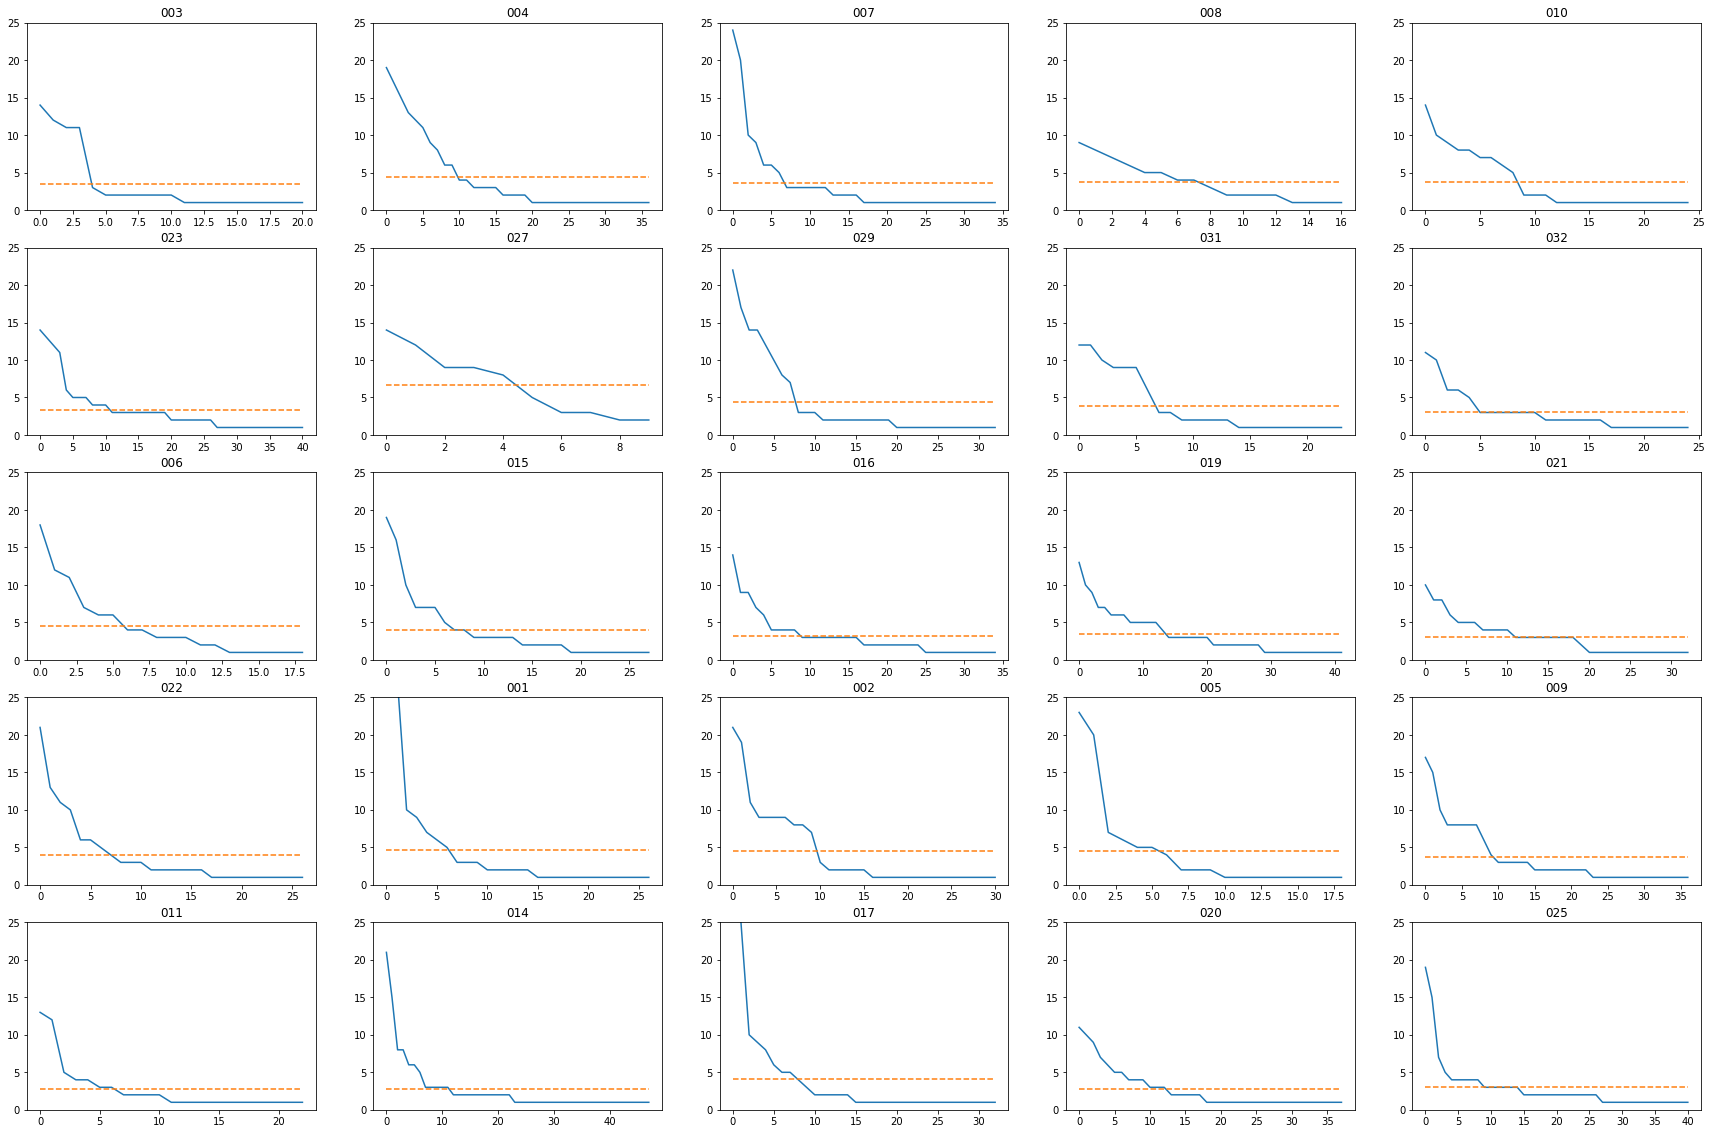

In [191]:
fig, axs = plt.subplots(5, 5, figsize=(30, 20))
for ax, par_id in zip(axs.reshape(-1), par_ids):
#     par_id = par_ids[0]

    y = df_subseq[df_subseq[par_id]>=1][par_id]
    y2 = df_subseq[df_subseq[par_id]>=2][par_id]
    x = np.arange(len(y))
    
    ax.set_title(par_id)
#     ax.scatter(x, y.values)
    ax.plot(x, sorted(y.values, reverse = True))

    
    y_mean = [np.mean(y)]*len(x)
    mean_line = ax.plot(x,y_mean, label='Mean', linestyle='--')
#     ax.set_xticks(x)
#     ax.set_xticklabels(list(y.keys()), rotation=90)
    ax.set_ylim([0,25])


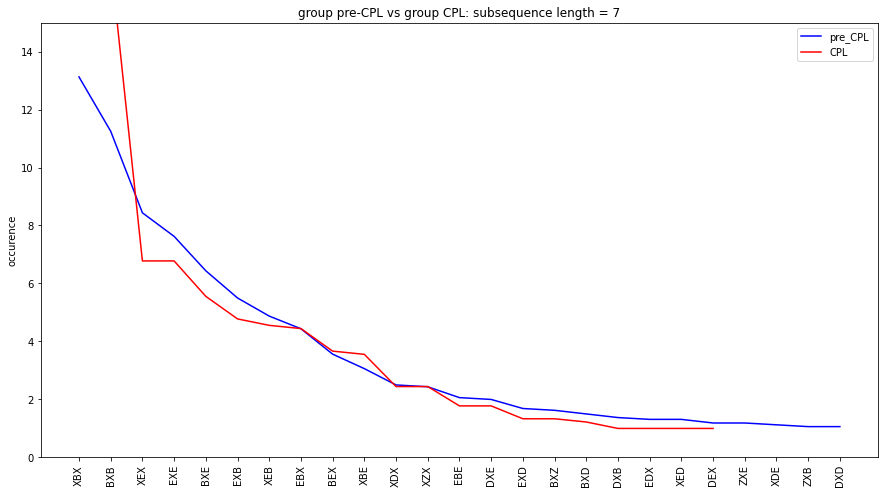

In [226]:
fig, ax = plt.subplots(figsize=(15, 8))


y1 = df_subseq[df_subseq["group1"]>=1]["group1"]
y2 = df_subseq[df_subseq["group2"]>=1]["group2"]
x1 = np.arange(len(y1))
x2 = np.arange(len(y2))

    
ax.set_title("group pre-CPL vs group CPL: subsequence length = 7")
#     ax.scatter(x, y.values)
ax.plot(x1, sorted(y1.values, reverse=True), color="b", label='pre_CPL')
ax.plot(x2, sorted(y2.values, reverse=True), color="r", label='CPL')


# y_mean1 = [np.mean(y1)]*len(x1)
# y_mean2 = [np.mean(y2)]*len(x2)

# mean_line1 = ax.plot(x1,y_mean1, label='Mean pre_CPL', linestyle='--', color = "b")
# mean_line1 = ax.plot(x2,y_mean2, label='Mean CPL', linestyle='--', color = "r")
ax.set_ylabel("occurence")
ax.set_xticks(x1)
ax.set_xticklabels(list(y1.keys()), rotation=90)
# ax.set_xticklabels(list(y1.keys()), rotation=90)

ax.set_ylim([0,15])
plt.legend()


In [240]:
length = 7
lsubseqcount = defaultdict(dict)
par_ids = df_res["par_id"]
for par_id, gaze_string in zip(par_ids, all_gaze_strings):
    subseqcount = defaultdict(int)
    for i in range(len(gaze_string)-length + 1):
        substring = gaze_string[i:i+length]
        subseqcount[substring] += 1
        
    sorted_subseqcount = {k: v for k, v in sorted(subseqcount.items(), key=lambda item: item[1], reverse=True)}
    lsubseqcount[par_id] = sorted_subseqcount
    
df_subseq = pd.DataFrame(lsubseqcount)

df_subseq["sum"] = df_subseq[par_ids].sum(1)

df_subseq["pre_CPL"] = df_subseq[par_ids[:16]].sum(1)/16
df_subseq["CPL"] = df_subseq[par_ids[16:]].sum(1)/9

df_subseq.sort_values(by=["sum"], ascending=False, inplace=True)

df_subseq[(df_subseq["pre_CPL"]>=1) & (df_subseq["CPL"]>=1)][["pre_CPL","CPL"]].to_csv("length{}.csv".format(length))

In [159]:
# df_res[["par_id", "exp"]]

y2.keys(),y1.keys()

(Index(['XBXBX', 'BXBXB', 'XEXBX', 'EXBXB', 'XBXEX', 'EXEXE', 'BXBXE', 'BXEXB',
        'EXEXB', 'XBEXB', 'EBXBX', 'BXEBX', 'XBXBE', 'BEXBX', 'EXBEX', 'BXBEX',
        'XBEXE'],
       dtype='object'),
 Index(['XBXBX', 'BXBXB', 'XEXEX', 'XEXBX', 'EXBXB', 'XBXEX', 'EXEXE', 'BXBXE',
        'BXEXB', 'EXEXB', 'XBEXB', 'EBXBX', 'BXEBX', 'EXBXE', 'XEBXB', 'XEBXE',
        'XBXEB', 'BXEXE', 'EXEBX', 'XEXEB', 'EBXEX'],
       dtype='object'))

In [114]:
df_res["transition"][2]

'XEXXZEXZXEBXBDEBXEXEXDXBXBXEXZBXZZXEEXBXEXEXBXEDEXBEXBXEBEBZXEBXEXEBEBXBEBXEXBXBEDXZBXBXXZXXXBXBXBXBXBXXBXXBXBXBXXBXEBXXXBXXXXXBXBXBXXEXXXXBXBXXXBX'

In [32]:
llength = list(range(3,8))
most_repeated_subseqs = []
for length in llength:
    subseq = defaultdict(int)

    for gaze_string in all_gaze_strings:
        for i in range(len(gaze_string)-length + 1):
            substring = gaze_string[i:i+length]
            subseq[substring] += 1

    sorted_subseq = {k: v for k, v in sorted(subseq.items(), key=lambda item: item[1], reverse=True)}
    most_repeated_subseqs.append(list(sorted_subseq.keys())[0])

In [33]:
for substr in most_repeated_subseqs:
    find = np.array(list(st.find_all(substr)))
    print(substr, len(find))
    r = []
    for i in range(len(ws) - 1):
        l = len(np.where((find > ws[i]) & (find < ws[i + 1]))[0])
        r.append(l)
    r.append(len(find) - sum(r))
    r = np.array(r) / np.array([len(v) for v in all_gaze_strings])
    df_res['n_{}'.format(substr)] = r

XBX 396
BXBX 242
XBXBX 196
BXBXBX 130
XBXBXBX 110


## Within pilot

In [34]:
llength = list(range(3,8))
lsubseqs = []
for length in llength:
    subseq_tables = []
    for gaze_string in all_gaze_strings:
        subseq_table = defaultdict(int)
        for i in range(len(gaze_string)-length + 1):
            substring = gaze_string[i:i+length]
            subseq_table[substring] += 1
            
        sorted_subseq = {k: v/(len(gaze_string)-length + 1) for k, v in sorted(subseq_table.items(), key=lambda item: item[1], reverse=True)}
        
        subseq_tables.append(sorted_subseq)
    
    lfreq = []
    for table in subseq_tables:
        min_freq = min(table.values())
        total_freq = 0
        for k,v in table.items():
            if v > min_freq:
                total_freq += v
                
        lfreq.append(total_freq)
        
    lsubseqs.append(lfreq)
        
# most_repeated_subseqs.append(list(sorted_subseq.keys())[0])

In [35]:
lsubseqs[0]

[0.8630136986301369,
 0.894409937888199,
 0.854838709677419,
 0.9365079365079365,
 0.860215053763441,
 0.8985507246376808,
 0.9402985074626865,
 0.909722222222222,
 0.8924731182795698,
 0.894736842105263,
 0.9310344827586204,
 0.9203539823008853,
 0.9099099099099097,
 0.9090909090909087,
 0.8725490196078431,
 0.9065420560747663,
 0.9055118110236219,
 0.8913043478260867,
 0.8941176470588236,
 0.8978102189781018,
 0.8125,
 0.8091603053435119,
 0.8666666666666668,
 0.8076923076923078,
 0.8852459016393446]

In [36]:
df_res["freq3"] = lsubseqs[0]
df_res["freq4"] = lsubseqs[1]
df_res["freq5"] = lsubseqs[2]
df_res["freq6"] = lsubseqs[3]
df_res["freq7"] = lsubseqs[4]

In [37]:
df_res

,index,par_id,group,transition,outside_fix_dur,outside_fix_rate,outside_fix_percent,left_panel_fix_dur,left_panel_fix_rate,left_panel_fix_percent,...,n_XBX,n_BXBX,n_XBXBX,n_BXBXBX,n_XBXBXBX,freq3,freq4,freq5,freq6,freq7
0,2,003,1,BXXBXXXXXXZEEXBXBXBEXEXXXEEXEXXEXXBXBXEBZZZXBX...,0.719049,7.237997,0.733988,0.000000,0.000000,0.000000,...,0.186667,0.106667,0.093333,0.040000,0.040000,0.863014,0.736111,0.605634,0.442857,0.260870
1,3,004,1,XEBXXEXBXZBXEXEXEBXEXEBZEZXEZXXEXEXEXEXEXXEXEB...,0.472027,7.188032,0.583547,0.000000,0.000000,0.000000,...,0.067485,0.030675,0.006135,0.000000,0.000000,0.894410,0.793750,0.540881,0.341772,0.178344
2,6,007,1,XEXXZEXZXEBXBDEBXEXEXDXBXBXEXZBXZZXEEXBXEXEXBX...,0.759839,7.540902,0.694248,0.000000,0.000000,0.000000,...,0.190476,0.134921,0.119048,0.095238,0.087302,0.854839,0.715447,0.491803,0.314050,0.216667
3,7,008,1,XXEBEEXXEEZXEEXXXXBXXEXXXXXXEXBEEXEXBXXXBXEBBX...,0.148007,11.347986,0.552926,0.000000,0.000000,0.000000,...,0.138462,0.046154,0.030769,0.000000,0.000000,0.936508,0.838710,0.606557,0.316667,0.135593
4,9,010,1,XEXEBEXXEEXXEBXEEXBBEXXXZXXXDBEXEXEXBXEBXBXZZX...,1.074082,5.901237,0.653912,0.000000,0.000000,0.000000,...,0.147368,0.073684,0.052632,0.010526,0.010526,0.860215,0.771739,0.604396,0.377778,0.213483
5,22,023,1,ZZZZZEXEXEBXBXZXEXZZXEBZXXBXEXZXDXEXBEXZXZEXXB...,0.550965,8.844731,0.685678,0.294014,0.106563,0.002735,...,0.100000,0.021429,0.007143,0.000000,0.000000,0.898551,0.729927,0.433824,0.214815,0.089552
6,26,027,1,BXXEXEXXXXXXBEXXXXXXBEXXXXEXEXXBXXEXXXXXXXEXXX...,0.486015,14.302799,0.758065,0.000000,0.000000,0.000000,...,0.202899,0.101449,0.086957,0.043478,0.043478,0.940299,0.939394,0.815385,0.687500,0.492063
7,28,029,1,XEXEXEBXXBXBXEXEXEXXEXEBXDEXEBXEZXEXEXEXEBZBXB...,0.738025,8.473016,0.635378,0.000000,0.000000,0.000000,...,0.150685,0.095890,0.075342,0.061644,0.041096,0.909722,0.783217,0.654930,0.482270,0.300000
8,29,031,1,XXEXEXXXXXEXXEXXPEBZZXXXEEDXEDZXEBXBXXBXEBDBXB...,0.360026,9.482708,0.593190,0.195958,0.104206,0.001945,...,0.126316,0.094737,0.063158,0.063158,0.031579,0.892473,0.804348,0.714286,0.533333,0.382022
9,30,032,1,XEXEXXXEZXXXZXZXXXEXXXPPXEXZXEXXZBXXXEXXEXXXXX...,0.716547,9.237243,0.769365,0.456512,0.256590,0.008388,...,0.128205,0.076923,0.038462,0.025641,0.012821,0.894737,0.733333,0.500000,0.287671,0.138889


In [53]:
df_res.to_csv("res.csv", index=False)

In [2]:
df_res = pd.read_csv("res.csv")

# statistical test

In [3]:
df_res.drop(columns=[ "transition"], inplace=True)

KeyError: "['transition'] not found in axis"

## ANOVA

In [ ]:
# df_res = pd.read_csv("res.csv")

In [42]:
import scipy.special as special

def FPvalue( *args):
    """ Return F an p value

    """
    df_btwn, df_within = __degree_of_freedom_( *args)

    mss_btwn = __ss_between_( *args) / float( df_btwn)   
    mss_within = __ss_within_( *args) / float( df_within)

    F = mss_btwn / mss_within    
    P = special.fdtrc( df_btwn, df_within, F)

    return( F, P)

def EffectSize( *args):
    """ Return the eta squared as the effect size for ANOVA

    """    
    return( float( __ss_between_( *args) / __ss_total_( *args)))

def __concentrate_( *args):
    """ Concentrate input list-like arrays

    """
    v = list( map( np.asarray, args))
    vec = np.hstack( np.concatenate( v))
    return( vec)

def __ss_total_( *args):
    """ Return total of sum of square

    """
    vec = __concentrate_( *args)
    ss_total = sum( (vec - np.mean( vec)) **2)
    return( ss_total)

def __ss_between_( *args):
    """ Return between-subject sum of squares

    """    
    # grand mean
    grand_mean = np.mean( __concentrate_( *args))

    ss_btwn = 0
    for a in args:
        ss_btwn += ( len(a) * ( np.mean( a) - grand_mean) **2)

    return( ss_btwn)

def __ss_within_( *args):
    """Return within-subject sum of squares

    """
    return( __ss_total_( *args) - __ss_between_( *args))

def __degree_of_freedom_( *args):
    """Return degree of freedom

       Output-
              Between-subject dof, within-subject dof
    """   
    args = list( map( np.asarray, args))
    # number of groups minus 1
    df_btwn = len( args) - 1

    # total number of samples minus number of groups
    df_within = len( __concentrate_( *args)) - df_btwn - 1

    return( df_btwn, df_within)

In [5]:
def oneway(df_res):
    cols = df_res.columns.tolist()[3:]
    df_g1 = df_res[df_res["group"] == 1]
    df_g2 = df_res[df_res["group"] == 2]
    df_g3 = df_res[df_res["group"] == 3]

    fval = []
    pval = []
    ez = []
    for col in cols:
        f,p = FPvalue(df_g1.loc[:,col], df_g2.loc[:,col], df_g3.loc[:,col])
        
        e = EffectSize(df_g1.loc[:,col], df_g2.loc[:,col], df_g3.loc[:,col])
        fval.append(f)
        pval.append(p)
        ez.append(e)

    return pd.DataFrame(zip(cols,fval,pval,ez), columns = ['ROI','F','pval',"effectSize"])

In [6]:
print("ANOVA 1 way test: missing = 15%, max_dist = 10, min_dur = 10")
oneway(df_res)

ANOVA 1 way test: missing = 15%, max_dist = 10, min_dur = 10


,ROI,F,pval,effectSize
0,outside_fix_dur,2.544987,1.013340e-01,0.187891
1,outside_fix_rate,1.589466,2.265892e-01,0.126254
2,outside_fix_percent,1.399054,2.679449e-01,0.112836
3,left_panel_fix_dur,0.471093,6.304736e-01,0.041068
4,left_panel_fix_rate,1.420045,2.630055e-01,0.114335
5,left_panel_fix_percent,0.557395,5.805774e-01,0.048228
6,ASI_fix_dur,2.574878,9.890638e-02,0.189680
7,ASI_fix_rate,4.156827,2.941902e-02,0.274254
8,ASI_fix_percent,4.338271,2.580947e-02,0.282840
9,ALT_fix_dur,0.922818,4.122413e-01,0.077399


In [7]:
import scipy
# standardized effect size - cohen's d 
def effect_size(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return abs((np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof))

    return d

def ttest(df_res):
    cols = df_res.columns.tolist()[3:]
    df_g1 = df_res[df_res["group"] != 3]
    df_g2 = df_res[df_res["group"] == 3]
    print("n_sample of 1st group: ", len(df_g1))
    print("n_sample of 2nd group: ", len(df_g2))

    tval = []
    pval = []
    ez = []
    for col in cols:
        t,p = scipy.stats.ttest_ind(df_g1.loc[:,col], df_g2.loc[:,col])
#         t,p = FPvalue(df_g1.loc[:,col], df_g2.loc[:,col])
        
        e = EffectSize(df_g1.loc[:,col], df_g2.loc[:,col])
        tval.append(t)
        pval.append(p)
        ez.append(e)
    
    return pd.DataFrame(zip(cols,tval,pval,ez), columns = ['ROI','tval','pval','effect size'])


In [147]:
import scipy
t,p = scipy.stats.ttest_ind(lvar[:16],lvar[16:])
e = EffectSize(lvar[:16],lvar[16:])
t,p,e

(-3.202775741844732, 0.003952371200874556, 0.3084323361459182)

In [8]:
g1 = df_res[df_res["group"] != 3]['exp']
g2 = df_res[df_res["group"] == 3]['exp']
EffectSize(g1,g2)


0.6726365143260529

In [9]:
ttest(df_res)

n_sample of 1st group:  16
n_sample of 2nd group:  9


,ROI,tval,pval,effect size
0,outside_fix_dur,-0.311045,7.585681e-01,0.004189
1,outside_fix_rate,0.777177,4.449749e-01,0.025589
2,outside_fix_percent,1.692824,1.039929e-01,0.110790
3,left_panel_fix_dur,-0.625439,5.378400e-01,0.016723
4,left_panel_fix_rate,0.679140,5.038270e-01,0.019659
5,left_panel_fix_percent,-0.121753,9.041519e-01,0.000644
6,ASI_fix_dur,0.423838,6.756217e-01,0.007750
7,ASI_fix_rate,-2.929895,7.529229e-03,0.271790
8,ASI_fix_percent,-2.631579,1.491484e-02,0.231417
9,ALT_fix_dur,0.744709,4.639894e-01,0.023545


(-2.5905515519082134, 0.016351886524562587, 0.2258748267717442)

In [10]:
df_res.columns

Index(['index', 'par_id', 'group', 'outside_fix_dur', 'outside_fix_rate',
       'outside_fix_percent', 'left_panel_fix_dur', 'left_panel_fix_rate',
       'left_panel_fix_percent', 'ASI_fix_dur', 'ASI_fix_rate',
       'ASI_fix_percent', 'ALT_fix_dur', 'ALT_fix_rate', 'ALT_fix_percent',
       'HSI_fix_dur', 'HSI_fix_rate', 'HSI_fix_percent', 'fix_dur', 'fix_rate',
       'blk_rate', 'sac_rate', 'Hs', 'Ht', 'exp', 'n_XBX', 'n_BXBX', 'n_XBXBX',
       'n_BXBXBX', 'n_XBXBXBX', 'freq3', 'freq4', 'freq5', 'freq6', 'freq7'],
      dtype='object')

In [11]:
print(df_res[df_res["group"] != 3][["Hs", "Ht"]].std())
print(df_res[df_res["group"] == 3][["Hs", "Ht"]].std())

Hs    0.265305
Ht    0.187752
dtype: float64
Hs    0.159244
Ht    0.172613
dtype: float64


In [12]:
print(df_res[df_res["group"] != 3][["n_XBX", "n_BXBX", "n_XBXBX", "n_BXBXBX", "n_XBXBXBX"]].std())
print(df_res[df_res["group"] == 3][["n_XBX", "n_BXBX", "n_XBXBX", "n_BXBXBX", "n_XBXBXBX"]].std())


n_XBX        0.056175
n_BXBX       0.040811
n_XBXBX      0.038295
n_BXBXBX     0.029598
n_XBXBXBX    0.024343
dtype: float64
n_XBX        0.054432
n_BXBX       0.054823
n_XBXBX      0.055279
n_BXBXBX     0.045335
n_XBXBXBX    0.045721
dtype: float64


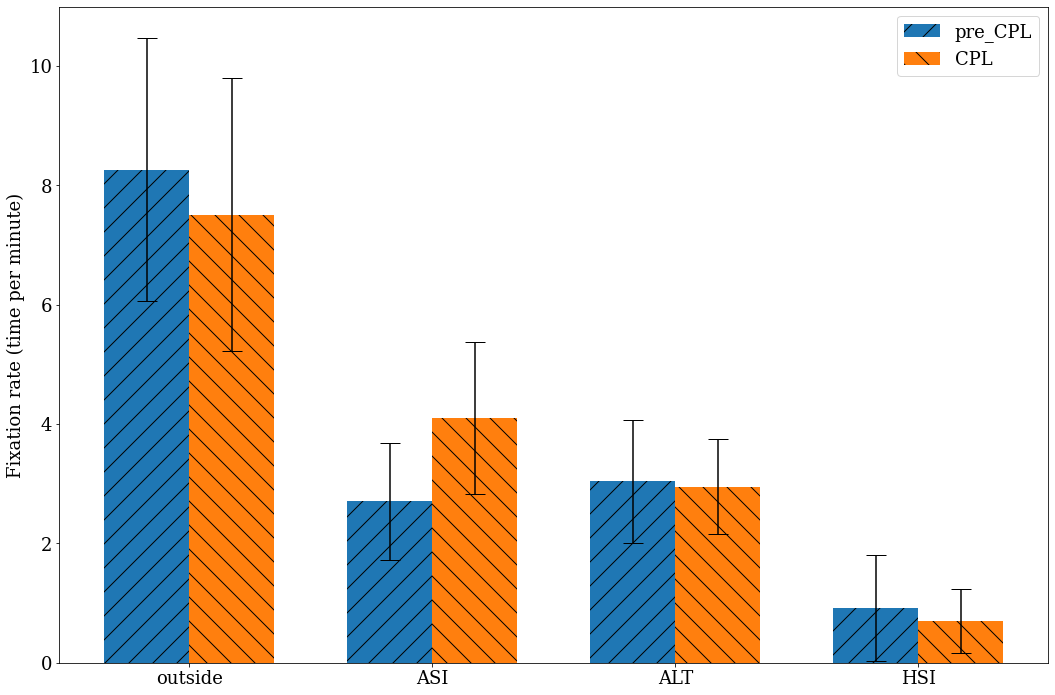

In [4]:
import matplotlib 

font = {'family' : 'serif',
        'size'   : 18}
matplotlib.rc('font', **font)

# cols = ["outside_fix_dur", "ASI_fix_dur", "ALT_fix_dur", "HSI_fix_dur"]
cols = ["outside_fix_rate", "ASI_fix_rate", "ALT_fix_rate", "HSI_fix_rate"]

pre_cpl = []
pre_cpl_std = []
cpl = []
cpl_std = []

for col in cols:
    g = df_res[col]
    pre_cpl.append(np.mean(g.iloc[:16]))
    cpl.append(np.mean(g.iloc[16:]))
    pre_cpl_std.append(np.std(g.iloc[:16]))
    cpl_std.append(np.std(g.iloc[16:]))
    
labels = [col.split("_")[0] for col in cols]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize = (15,10))
rects1 = ax.bar(x - width/2, pre_cpl, width, label='pre_CPL', yerr=pre_cpl_std, capsize = 10, hatch='/')
rects2 = ax.bar(x + width/2, cpl, width, label='CPL', yerr=cpl_std, capsize = 10, hatch='\\')

# bars = [rects1, rects2]
# # patterns = ('-', '+', 'x', '\\', '*', 'o', 'O', '.')
# patterns = ('-', '\\')
# for bar, pattern in zip(bars, patterns):
#     bar.set_hatch(pattern)

# Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Mean fixation duration (s)')
ax.set_ylabel('Fixation rate (time per minute)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(np.round(height,2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# ax.grid(axis='y')
# autolabel(rects1)
# autolabel(rects2)

fig.tight_layout()


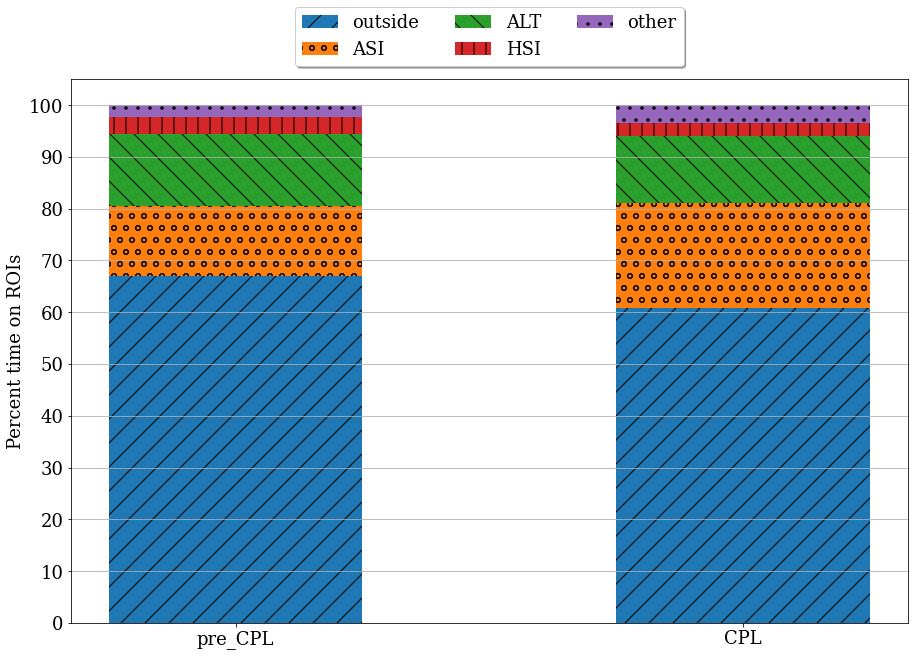

In [28]:
cols = ["outside_fix_percent", "ASI_fix_percent", "ALT_fix_percent", "HSI_fix_percent"]
pre_cpl = []
pre_cpl_std = []
cpl = []
cpl_std = []

for col in cols:
    g = df_res[col]
    pre_cpl.append(np.mean(g.iloc[:16]) * 100)
    cpl.append(np.mean(g.iloc[16:]) * 100)
    pre_cpl_std.append(np.std(g.iloc[:16]))
    cpl_std.append(np.std(g.iloc[16:]))
    
pre_cpl.append(100 - sum(pre_cpl))
cpl.append(100 - sum(cpl))

data = np.array([pre_cpl, cpl]).T
    
ind = np.arange(2)    # the x locations for the groups
width = 0.2       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize = (15,10))

ind = [0.3,0.7]
p1 = ax.bar(ind, data[0], width, label='outside', hatch = "/")
p2 = ax.bar(ind, data[1], width, bottom=data[0], label='ASI', hatch = "o")
p3 = ax.bar(ind, data[2], width, bottom=[i+j for i,j in zip(data[0], data[1])], label='ALT', hatch = "\\")
p4 = ax.bar(ind, data[3], width, bottom=[i+j+k for i,j,k in zip(data[0], data[1], data[2])], label='HSI', hatch = "|")
p5 = ax.bar(ind, data[4], width, bottom=[i+j+k+l for i,j,k,l in zip(data[0], data[1], data[2], data[3])], label='other', hatch = ".")

ax.grid(axis='y')
ax.set_ylabel('Percent time on ROIs')
ax.set_xticks((0.3, 0.7))
ax.set_xticklabels(['pre_CPL', 'CPL'])
ax.set_yticks(np.arange(0, 101, 10))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=3, fancybox=True, shadow=True)

In [16]:
ls_group = []
ls_roi_id = []
ls_val = []
# for i in range(len(df_res[["group","outside_fix_dur", "ASI_fix_dur", "ALT_fix_dur", "HSI_fix_dur"]])):
for i in range(len(df_res[["group","outside_fix_rate", "ASI_fix_rate", "ALT_fix_rate", "HSI_fix_rate"]])):
# for i in range(len(df_res[["group","outside_fix_dur", "ASI_fix_dur", "ALT_fix_dur", "HSI_fix_dur"]])):

    x = df_res.iloc[i]
    if x["group"] == 1 or x["group"] == 2:
        gr = 0
    else:
        gr = 1
        
#     for j,v in enumerate(["outside_fix_dur", "ASI_fix_dur", "ALT_fix_dur", "HSI_fix_dur"]):
    for j,v in enumerate(["outside_fix_rate", "ASI_fix_rate", "ALT_fix_rate", "HSI_fix_rate"]):

        ls_group.append(gr)
        ls_roi_id.append(j)
        ls_val.append(x[v])

In [17]:
df_anova = pd.DataFrame(zip(ls_group, ls_roi_id, ls_val), columns = ["group", "ROI", "value"])
df_anova

,group,ROI,value
0,0,0,7.237997
1,0,1,2.083666
2,0,2,1.973999
3,0,3,0.109667
4,0,0,7.188032
...,...,...,...
95,1,3,1.243888
96,1,0,6.584129
97,1,1,4.735953
98,1,2,3.465331


In [18]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

#perform two-way ANOVA
model = ols('value ~ C(group) + C(ROI) + C(group):C(ROI)', data=df_anova).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(group),0.152383,1.0,0.072924,7.877303e-01
C(ROI),682.201063,3.0,108.824478,3.734669e-30
C(group):C(ROI),14.607722,3.0,2.330219,7.946004e-02
Residual,192.243813,92.0,NaN,NaN


In [19]:
a1 = df_anova[df_anova["ROI"] == 0]['value']
a2 = df_anova[df_anova["ROI"] == 1]['value']
a3 = df_anova[df_anova["ROI"] == 2]['value']
a4 = df_anova[df_anova["ROI"] == 3]['value']

a5 = df_anova[df_anova["group"] == 0]['value']
a6 = df_anova[df_anova["group"] == 1]['value']

print("ES group", EffectSize(a5,a6))
print("ES ROI", EffectSize(a1,a2,a3,a4))

ES group 0.00017137034683108274
ES ROI 0.767203375449898


## Pairwise Tukey's HSD test

In [20]:
#post-hoc analysis using Tukey
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# perform multiple pairwise comparison (Tukey HSD)
m_comp = pairwise_tukeyhsd(endog=df_anova['value'], groups=df_anova['ROI'], alpha=0.05)
print(m_comp)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     0      1  -4.7822 0.001 -5.8682 -3.6962   True
     0      2  -4.9857 0.001 -6.0717 -3.8997   True
     0      3  -7.1488 0.001 -8.2348 -6.0628   True
     1      2  -0.2035   0.9 -1.2895  0.8824  False
     1      3  -2.3666 0.001 -3.4526 -1.2806   True
     2      3  -2.1631 0.001 -3.2491 -1.0771   True
---------------------------------------------------


In [21]:
# p_values = psturng(np.abs(res2.meandiffs / res2.std_pairs), len(res2.groupsunique), res2.df_total)


In [22]:
df_res[["par_id", "group", "exp"]].sort_values(["group","exp"])

,par_id,group,exp
9,32,1,10
6,27,1,18
8,31,1,26
1,4,1,35
3,8,1,35
4,10,1,35
7,29,1,40
0,3,1,42
2,7,1,49
5,23,1,50


In [7]:
df_res.

AttributeError: 'DataFrame' object has no attribute 'title'

In [20]:
x = df_res[['par_id', 'group','exp',"outside_fix_dur", "ASI_fix_dur", "ALT_fix_dur", "HSI_fix_dur",
                                    "outside_fix_rate", "ASI_fix_rate", "ALT_fix_rate", "HSI_fix_rate"]]

In [28]:
df_x = pd.DataFrame()
for v in x.values:
    df2 = pd.DataFrame([[v[0],v[1],v[2],"outside",v[3], v[3+4]],
                        [v[0],v[1],v[2],"ASI",v[4], v[4+4]],
                        [v[0],v[1],v[2],"ALT",v[5], v[5+4]],
                        [v[0],v[1],v[2],"HSI",v[6], v[6+4]]], columns=['par_id', 'group','exp','roi','fix_dur','fix_rate'])
    df_x = df_x.append(df2, ignore_index=True)

In [30]:
df_x.to_csv("res2.csv")